In [1]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time

In [2]:
# Defining the function from test script
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]

# Loading in our data
pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
pars2=np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);

# Question 1

In [3]:
model1=get_spectrum(pars)
model1=model1[:len(spec)]
resid1=spec-model1
dof = len(resid1)-len(pars)
chisq1=np.sum( (resid1/errs)**2)
print("old param chisq is ",chisq1," for ",dof," degrees of freedom.")
print("chi square is", abs((chisq1-dof)/(2*dof)), 'standard deviations from the mean')

old param chisq is  15267.937968222595  for  2501  degrees of freedom.
chi square is 2.5523666469857247 standard deviations from the mean


2.5 standard deviations from the mean for the old params is not a very good fit (approx 0.5 percentile), implication is model is likely incorrect.

In [4]:
model2=get_spectrum(pars2)
model2=model2[:len(spec)]
resid2=spec-model2
chisq2=np.sum( (resid2/errs)**2)
print("\nnew param chisq is ",chisq2," for ",len(resid2)-len(pars2)," degrees of freedom.")
print("chi square is", abs((chisq2-dof)/(2*dof)), 'standard deviations from the mean')


new param chisq is  3272.2033778089576  for  2501  degrees of freedom.
chi square is 0.15417900396020745 standard deviations from the mean


0.15 standard deviations fro the mean for the new params is a good fit (approx 45 percentile).

# Question 2

In [5]:
# This function will calculate a numerical derivative
def f(fun,param,dxfrac):

    y = fun(param,lmax=3000)[:len(spec)]
    p = np.zeros((6, 6))
    
    # Creating an array of dx's for params for to use when calculating deriv
    p=np.stack(([param[0]*dxfrac,0,0,0,0,0], [0,param[1]*dxfrac,0,0,0,0], [0,0,param[2]*dxfrac,0,0,0], [0,0,0,param[3]*dxfrac,0,0],\
    [0,0,0,0,param[4]*dxfrac,0], [0,0,0,0,0,param[5]*dxfrac]))
    
    derivs=np.zeros([len(spec),len(param)])
    # Calculate derivs for each param at each data point
    for i in range(len(param)):
        derivs[:,i]=(fun(param+p[:,i],lmax=3000)[:len(spec)] - fun(param-p[:,i],lmax=3000)[:len(spec)])/(2*param[i]*.001)
    return (y,derivs)

In [6]:
# Will start with best param guesses from Q1
pars_guess=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])

pars_cur=pars_guess.copy()

# This code will execute the newton's method param fitter
N=np.eye(len(ell))*errs**2
Ninv=np.eye(len(ell))/errs**2
old_step = np.asarray([1,1,1,1,1,1])
for iter in range(100):
    y_pred,derivs=f(get_spectrum,pars_cur,0.005)
    resid=spec-y_pred #data minus current model
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
    step=np.linalg.inv(lhs)@rhs
    pars_cur=pars_cur+step
    print('iteration ',iter,' has new params ',pars_cur)
    # We'll run newtons method until avg change in param is less than 0.001x
    if abs(np.mean((step)/(pars_cur))) < 0.001:
        print('avg fractional change in param is', abs(np.mean((step)/(pars_cur))))
        break
    else:
        print('avg fractional change in param is', abs(np.mean((step)/(pars_cur))))
        old_step=step
        pass
par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ',pars_cur,' with errors ',par_errs)

iteration  0  has new params  [6.88811864e+01 2.20755504e-02 1.19443294e-01 7.01509119e-02
 2.14394303e-09 9.54938502e-01]
avg fractional change in step size is 0.027900929729327454
iteration  1  has new params  [6.87759476e+01 2.21348029e-02 1.19027611e-01 7.60182131e-02
 2.17043804e-09 9.58795298e-01]
avg fractional change in step size is 0.015177831961111748
iteration  2  has new params  [6.86836807e+01 2.21814653e-02 1.18718259e-01 7.94311215e-02
 2.18651522e-09 9.61801566e-01]
avg fractional change in step size is 0.008599996595606703
iteration  3  has new params  [6.86056510e+01 2.22185571e-02 1.18483611e-01 8.14397541e-02
 2.19641391e-09 9.64157584e-01]
avg fractional change in step size is 0.00502766628870949
iteration  4  has new params  [6.85409258e+01 2.22481689e-02 1.18303079e-01 8.26605465e-02
 2.20272568e-09 9.66012227e-01]
avg fractional change in step size is 0.003069118549586275
iteration  5  has new params  [6.84876951e+01 2.22717555e-02 1.18162734e-01 8.34155467e-02


In [7]:
# Saving those params
par_labels = ['H0','ombh2','omch2','tau','As','ns']
newton_par_err = np.dstack([par_labels,pars_cur,par_errs])
print(newton_par_err)
np.savetxt("planck_fit_params.txt", newton_par_err[0], fmt='%s')

[[['H0' '68.40711585577048' '0.23908312930981335']
  ['ombh2' '0.022305458895000418' '4.578092897123014e-05']
  ['omch2' '0.11797034165561604' '0.0005358953840853283']
  ['tau' '0.0841604355852194' '0.0068529949887014665']
  ['As' '2.2113395822558098e-09' '2.8650590275432675e-11']
  ['ns' '0.9695444549558756' '0.0013193857756125735']]]


# Question 2 Bonus

In [8]:
# This is how I would do it, commented out cause I couldn't make it converge.
'''
def get_spectrum_nodm(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=0
    tau=pars[2]
    As=pars[3]
    ns=pars[4]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]

def f_nodm(fun,param,dxfrac):
    y = fun(param,lmax=3000)[:len(spec)]
    p = np.zeros((5, 5))
    
    p=np.stack(([param[0]*dxfrac,0,0,0,0], [0,param[1]*dxfrac,0,0,0], [0,0,param[2]*dxfrac,0,0], [0,0,0,param[3]*dxfrac,0],\
    [0,0,0,0,param[4]*dxfrac]))
    
    derivs=np.zeros([len(spec),len(param)])
    for i in range(len(param)):
        derivs[:,i]=(fun(param+p[:,i],lmax=3000)[:len(spec)] - fun(param-p[:,i],lmax=3000)[:len(spec)])/(2*param[i]*.001)
    return (y,derivs)
'''

"\ndef get_spectrum_nodm(pars,lmax=3000):\n    #print('pars are ',pars)\n    H0=pars[0]\n    ombh2=pars[1]\n    omch2=0\n    tau=pars[2]\n    As=pars[3]\n    ns=pars[4]\n    pars=camb.CAMBparams()\n    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)\n    pars.InitPower.set_params(As=As,ns=ns,r=0)\n    pars.set_for_lmax(lmax,lens_potential_accuracy=0)\n    results=camb.get_results(pars)\n    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')\n    cmb=powers['total']\n    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE\n    return tt[2:]\n\ndef f_nodm(fun,param,dxfrac):\n    y = fun(param,lmax=3000)[:len(spec)]\n    p = np.zeros((5, 5))\n    \n    p=np.stack(([param[0]*dxfrac,0,0,0,0], [0,param[1]*dxfrac,0,0,0], [0,0,param[2]*dxfrac,0,0], [0,0,0,param[3]*dxfrac,0],    [0,0,0,0,param[4]*dxfrac]))\n    \n    derivs=np.zeros([len(spec),len(param)])\n    for i in range(len(param)):\n        derivs[:,i]=(fun(param+p[:,i]

In [9]:
'''
pars_guess_nodm=np.asarray([69,0.022,0.06,2.1e-9,0.95])

pars_cur_nodm=pars_guess_nodm.copy()

N=np.eye(len(ell))*errs**2
Ninv=np.eye(len(ell))/errs**2
old_step = np.asarray([1,1,1,1,1])
for iter in range(100):
    y_pred,derivs=f_nodm(get_spectrum_nodm,pars_cur_nodm,0.005)
    resid=spec-y_pred #data minus current model
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
    step=np.linalg.inv(lhs)@rhs
    pars_cur_nodm=pars_cur_nodm+step
    print('iteration ',iter,' has new params ',pars_cur_nodm)
    # We'll run newtons method until avg change in step size is less than 0.01x
    if abs(np.mean((step)/(pars_cur_nodm))) < 0.001:
        print('avg fractional change in param is', abs(np.mean((step)/(pars_cur_nodm))))
        break
    else:
        print('avg fractional change in step size is', abs(np.mean((step)/(pars_cur_nodm))))
        old_step=step
        pass
par_errs_nodm=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ',pars_cur_nodm,' with errors ',par_errs_nodm)
'''

"\npars_guess_nodm=np.asarray([69,0.022,0.06,2.1e-9,0.95])\n\npars_cur_nodm=pars_guess_nodm.copy()\n\nN=np.eye(len(ell))*errs**2\nNinv=np.eye(len(ell))/errs**2\nold_step = np.asarray([1,1,1,1,1])\nfor iter in range(100):\n    y_pred,derivs=f_nodm(get_spectrum_nodm,pars_cur_nodm,0.005)\n    resid=spec-y_pred #data minus current model\n    rhs=derivs.T@(Ninv@resid)\n    lhs=derivs.T@Ninv@derivs\n    step=np.linalg.inv(lhs)@rhs\n    pars_cur_nodm=pars_cur_nodm+step\n    print('iteration ',iter,' has new params ',pars_cur_nodm)\n    # We'll run newtons method until avg change in step size is less than 0.01x\n    if abs(np.mean((step)/(pars_cur_nodm))) < 0.001:\n        print('avg fractional change in param is', abs(np.mean((step)/(pars_cur_nodm))))\n        break\n    else:\n        print('avg fractional change in step size is', abs(np.mean((step)/(pars_cur_nodm))))\n        old_step=step\n        pass\npar_errs_nodm=np.sqrt(np.diag(np.linalg.inv(lhs)))\nprint('final parameters are ',pars_

In [10]:
'''
pars_labels_nodm = ['H0','ombh2','tau','As','ns']
newton_par_err_nodm = np.dstack([par_labels_nodm,pars_cur_nodm,par_errs_nodm])
np.savetxt("planck_fit_params_nodm.txt", newton_par_err_nodm[0])
'''

'\npars_labels_nodm = [\'H0\',\'ombh2\',\'tau\',\'As\',\'ns\']\nnewton_par_err_nodm = np.dstack([par_labels_nodm,pars_cur_nodm,par_errs_nodm])\nnp.savetxt("planck_fit_params_nodm.txt", newton_par_err_nodm[0])\n'

# Question 3

In [11]:
# Here's the MCMC function
def mcmc(pars,step_size,par_errs,fun,nstep=1000):
    vals_curr = fun(pars,lmax=3000)[:len(spec)]
    residcurr=spec-vals_curr
    chi_cur=np.sum( (residcurr/errs)**2)
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    for i in range(nstep):
        pars_trial=pars+step_size*np.random.randn(npar)
        
        vals_trial = fun(pars_trial,lmax=3000)[:len(spec)]
        residtrial=spec-vals_trial
        chi_trial=np.sum( (residtrial/errs)**2)
        
        delta_chisq=chi_trial-chi_cur
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            pars=pars_trial
            chi_cur=chi_trial
        chain[i,:]=pars
        chivec[i]=chi_cur
        if i%100 == 0:
            print(i)
    return chain,chivec

In [14]:
# run mcmc chain for 5000 steps. Take param steps to be err in params from newtons method
mcmcstep=par_errs
chain1,chisq1=mcmc(pars_cur,mcmcstep,errs,get_spectrum,nstep=5000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [17]:
pars_labels_mcmc = ['chi','H0','ombh2','omch2','tau','As','ns']
planckchain = np.hstack((np.array([chisq1]).T,chain1))
placnkchain = np.vstack((pars_labels_mcmc,planckchain))
np.savetxt("planck_chain.txt", placnkchain, fmt='%s') 

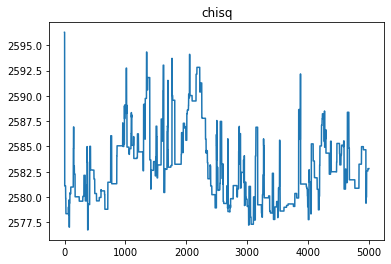

In [59]:
# plot of chisq chain
plt.plot(chisq1)
plt.title('chisq')
plt.savefig('P3a.png')

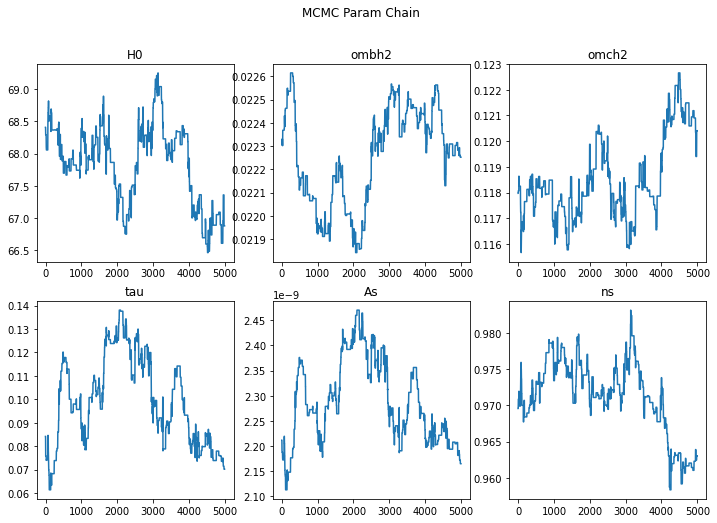

In [40]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,8))
fig.suptitle('MCMC Param Chain')
ax1.plot(chain1[:,0])
ax1.title.set_text('H0')
ax2.plot(chain1[:,1])
ax2.title.set_text('ombh2')
ax3.plot(chain1[:,2])
ax3.title.set_text('omch2')
ax4.plot(chain1[:,3])
ax4.title.set_text('tau')
ax5.plot(chain1[:,4])
ax5.title.set_text('As')
ax6.plot(chain1[:,5])
ax6.title.set_text('ns')
plt.savefig('P3b.png')

In [49]:
chain1avgs = np.mean(chain1,axis=0)
chain1errs = np.std(chain1,axis=0)
for i in range(6):
    print(par_labels[i], '=', chain1avgs[i], 'with err', chain1errs[i], '\n')

H0 = 67.8395674609882 with err 0.6069755039168293 

ombh2 = 0.022255019292289468 with err 0.0002100004839845466 

omch2 = 0.11851235755084781 with err 0.0015734748816593443 

tau = 0.0992392375683886 with err 0.018835572189939028 

As = 2.2876283669102755e-09 with err 8.260536899975353e-11 

ns = 0.9711976384511841 with err 0.005100049416699436 



I don't think my chains have converged, they and the chi square chain do not appear gaussian. I think this may be a step size issue or a not running a long enough chain issue. However, the chisquare chain is very consistent 



In [55]:
H0 = chain1avgs[0]
ombh2 = chain1avgs[1]
omch2 = chain1avgs[2]
H0err = chain1errs[0]
ombh2err = chain1errs[1]
omch2err = chain1errs[2]
omlam = 1-10**4/H0**2*(ombh2+omch2)
omlamerr = 10**4*np.sqrt(H0**2*(ombh2err**2+omch2err**2)+4*H0err**2*(ombh2+omch2)**2)/H0**3
print('omlam = ', omlam, 'with err', omlamerr)

omlam =  0.6941307083857625 with err 0.006469555262901382


# Question 4

In [41]:
# For tau fixed, we are going to force it to be 0.054 without any variation at all.
def get_spectrum_taufix(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=0.054
    As=pars[3]
    ns=pars[4]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]

In [42]:
def mcmc_taufix(pars,step_size,errs,fun,nstep=1000):
    vals_curr = fun(pars,lmax=3000)[:len(spec)]
    residcurr=spec-vals_curr
    chi_cur=np.sum( (residcurr/errs)**2)
    print(chi_cur)
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    for i in range(nstep):
            
        pars_trial=pars+step_size*np.random.randn(npar)
        vals_trial = fun(pars_trial,lmax=3000)[:len(spec)]
        residtrial=spec-vals_trial
        chi_trial=np.sum( (residtrial/errs)**2)

        delta_chisq=chi_trial-chi_cur
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            pars=pars_trial
            chi_cur=chi_trial
        chain[i,:]=pars
        chivec[i]=chi_cur
        if i%100 == 0:
            print(i)
            print(chi_trial)
            
    return chain,chivec

In [43]:
pars_cur_taufix = np.delete(pars_cur, 3)
mcmcstep_taufix = np.delete(mcmcstep, 3)

chain1_taufix,chisq1_taufix=mcmc_taufix(pars_cur_taufix,mcmcstep_taufix,errs,get_spectrum_taufix,nstep=5000)

KeyboardInterrupt: 

In [76]:
pars_labels_mcmc_taufix = ['H0','ombh2','omch2','As','ns','chi']
planckchain_taufix = np.hstack((chain1_taufix,np.array([chisq1_taufix]).T))
placnkchain_taufix = np.vstack((pars_labels_mcmc_taufix,planckchain_taufix))
np.savetxt("planck_chain_tauprior.txt", placnkchain_taufix, fmt='%s') 

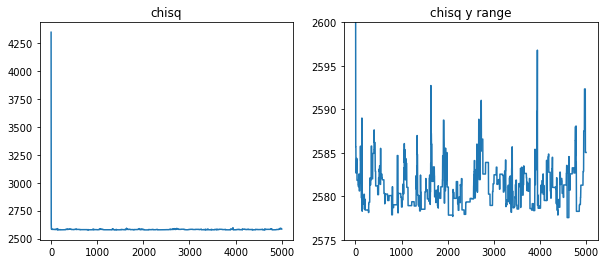

In [77]:
# plot of chisq chain
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(chisq1_taufix)
ax1.title.set_text('chisq')
ax2.plot(chisq1_taufix)
ax2.title.set_text('chisq y range')
ax2.set_ylim([2575,2600])

plt.savefig('P4a.png')

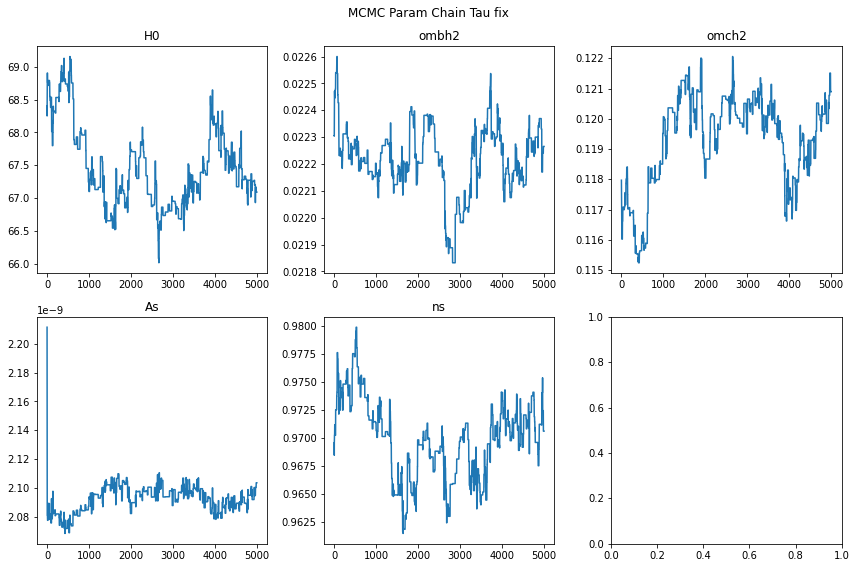

In [78]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,8))
fig.suptitle('MCMC Param Chain Tau fix')
ax1.plot(chain1_taufix[:,0])
ax1.title.set_text('H0')
ax2.plot(chain1_taufix[:,1])
ax2.title.set_text('ombh2')
ax3.plot(chain1_taufix[:,2])
ax3.title.set_text('omch2')
ax4.plot(chain1_taufix[:,3])
ax4.title.set_text('As')
ax5.plot(chain1_taufix[:,4])
ax5.title.set_text('ns')
plt.tight_layout()

plt.savefig('P4b.png')

In [81]:
chain1avgs_taufix = np.mean(chain1_taufix,axis=0)
chain1errs_taufix = np.std(chain1_taufix,axis=0)
for i in range(5):
    print(pars_labels_mcmc_taufix[i], '=', chain1avgs_taufix[i], 'with err', chain1errs_taufix[i], '\n')

H0 = 67.47207045450766 with err 0.6105441818003493 

ombh2 = 0.02221516582495259 with err 0.00012662408260275364 

omch2 = 0.11929703432444409 with err 0.0015312696644209827 

As = 2.092338320215308e-09 with err 8.687713427251079e-12 

ns = 0.9698355148289526 with err 0.003472385623409476 



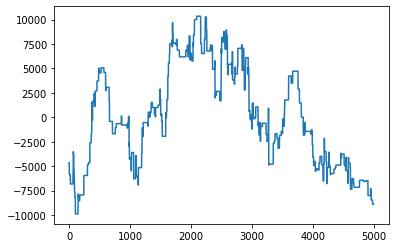

In [111]:
# Importance sampling framework. Not sure if I am doing this right

# Making our expectation parameters and errors those from our tau fixed chain, inserting the fixed tau in there
pars_expec = np.insert(chain1avgs_taufix,3,0.054)
pars_expec_errs = np.insert(chain1errs_taufix,3,0.0074)

# Most of this is based on John's code but I am not entirely sure what I'm doing
def prior_chisq(pars,par_priors,par_errs):
    if par_priors is None:
        return 0
    par_shifts=pars-par_errs
    return np.sum((par_shifts/par_errs)**2)

# I'm assuming the weight to be the ratio of param at each step in chain to "expectation param" in tau fix
weight=np.zeros((5000,6))
chivec_samp=np.zeros(5000)
for i in range(5000):
    chisq_samp=prior_chisq(chain1[i,:],pars_expec,pars_expec_errs)
    chivec_samp[i]=chisq_samp
chivec_samp=chivec_samp-chivec_samp.mean()
plt.plot(chivec_samp)
#weight=np.exp(0.5*chivec_samp)
for i in range(5000):
    for j in range(6):
        weight[i,j] = chain1[i,j]/pars_expec[j]


In [116]:
for i in range(6):
    print('importance sampled ',par_labels[i],' has mean ',np.sum(weight[:,i]*chain1[:,i])/np.sum(weight[:,i]))

importance sampled  H0  has mean  67.84499820407873
importance sampled  ombh2  has mean  0.022257000876879224
importance sampled  omch2  has mean  0.11853324839509598
importance sampled  tau  has mean  0.10281422250796769
importance sampled  As  has mean  2.2906112145993017e-09
importance sampled  ns  has mean  0.9712244203367953


# Question 4 Bonus

In [117]:
chain1avgs = np.mean(chain1,axis=0)
chain1errs = np.std(chain1,axis=0)
for i in range(6):
    print(par_labels[i], '=', chain1avgs[i], 'with err', chain1errs[i]*5, '\n')

H0 = 67.8395674609882 with err 3.0348775195841466 

ombh2 = 0.022255019292289468 with err 0.001050002419922733 

omch2 = 0.11851235755084781 with err 0.007867374408296721 

tau = 0.0992392375683886 with err 0.09417786094969514 

As = 2.2876283669102755e-09 with err 4.130268449987677e-10 

ns = 0.9711976384511841 with err 0.025500247083497178 

